In [ ]:
import json
import datetime
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Extract data

In [ ]:
def json_to_matrix(json_file):
  with open(json_file) as f:
    data = json.load(f)
  dates = []
  categories_id = []
  categories = []
  I = len(data)
  i = 0
  for element in data:
    date, time = element["date"].split("T")
    year, month, day = date.split("-")
    time = time.split(".")[0]
    hour, min, sec = time.split(":")
    date = datetime.datetime(int(year), int(month), int(day), int(hour), int(min))
    dates.append(date)
    for category in element["categories"]:
      if len(categories_id) == 0:
        categories_id.append(category["category"]["id"])
        categories.append(category["category"]["name"])
        M = np.zeros((I, 1))
        M[0, 0] = category["percentage"]
      else:
        if category["category"]["id"] in categories_id:
          j = categories_id.index(category["category"]["id"])
          M[i, j] = category["percentage"]
        else:
          categories_id.append(category["category"]["id"])
          categories.append(category["category"]["name"])
          j = len(categories_id)-1
          column = np.zeros((I, 1))
          M = np.concatenate([M, column], axis=1)
          M[i, j] = category["percentage"]
    i += 1
  return M, dates, categories_id, categories

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/My Drive/Naveler/03.TECH/data_discovery/datasets/data.json'
M, dates, categories_id, categories = json_to_matrix(DATA_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
assert len(categories_id) == len(categories), 'Should be equal'

In [ ]:
df = pd.DataFrame(M, index=dates, columns=categories)
df.head()

,SECTOR Energía,Sector eléctrico,Consumo eléctrico,Impacto energético,Vulnerabilidad energética,Cambio climático,Calidad aire,Innovación,Movilidad sostenible,Gestión del agua,Redes eléctricas,Tarifas / mediciones eléctricas,Eficiencia energética,Smart Grids,GNL maritimo
2022-01-03,100.0,71.43,42.86,28.57,28.57,28.57,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
2022-01-04,100.0,0.00,0.00,91.67,0.00,33.33,33.33,25.00,25.00,25.00,0.0,0.0,0.0,0.0,0.0
2022-01-09,100.0,40.00,40.00,0.00,0.00,0.00,0.00,60.00,60.00,0.00,20.0,0.0,0.0,0.0,0.0
2022-01-10,100.0,0.00,0.00,100.00,0.00,35.29,17.65,0.00,0.00,47.06,0.0,0.0,0.0,0.0,0.0
2022-01-11,100.0,0.00,0.00,92.86,0.00,21.43,0.00,7.14,7.14,71.43,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Transform dates into numerical values in order to make to a regression
# Each numerical date will be equivalent to the number of days with respect to the initial date
numerical_dates = [(date - dates[0]).days for date in dates]

# Standard Linear Regression

Use data from January to June as training data and use data from July as test data

In [ ]:
i_split = dates.index(datetime.datetime(2022, 7, 1))
train1_dates = dates[:i_split]
test1_dates = dates[i_split:]

In [ ]:
X_train1 = np.array(numerical_dates[:i_split])
X_test1 = np.array(numerical_dates[i_split:])
Y_train1 = df[:i_split]
Y_test1 = df[i_split:]

In [ ]:
model1 = LinearRegression()
model1.fit(X_train1.reshape(-1 ,1), Y_train1)

LinearRegression()

In [ ]:
#model1.intercept_

In [ ]:
#model1.coef_

# Windowing Linear Regression

Use data from June as training data and use data from July as test data

In [ ]:
i_start_train = dates.index(datetime.datetime(2022, 6, 1))
i_end_train = dates.index(datetime.datetime(2022, 7, 1))
train2_dates = dates[i_start_train:i_end_train]
test2_dates = dates[i_end_train:]

In [ ]:
X_train2 = np.array(numerical_dates[i_start_train:i_end_train])
X_test2 = np.array(numerical_dates[i_end_train:])
Y_train2 = df[i_start_train:i_end_train]
Y_test2 = df[i_end_train:]

In [ ]:
model2 = LinearRegression()
model2.fit(X_train2.reshape(-1 ,1), Y_train2)

LinearRegression()

# Predictions

In [ ]:
def plot_category(category):
  i_cat = categories.index(category)
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
  fig.set_size_inches(20, 6)

  ax1.plot(dates, df[category], label='data')
  train_predict1 = model1.predict(X_train1.reshape(-1, 1))[:, i_cat]
  test_predict1 = model1.predict(X_test1.reshape(-1, 1))[:, i_cat]
  ax1.plot(train1_dates, train_predict1, color='orange', label='train prediction')
  ax1.plot(test1_dates, test_predict1, color='green', label='test prediction')
  ax1.set_title('Standard Linear Regression')
  ax1.set_xlabel("date")
  ax1.set_ylabel("percentage (%)")
  ax1.grid()
  
  ax2.plot(dates, df[category])
  train_predict2 = model2.predict(X_train2.reshape(-1, 1))[:, i_cat]
  test_predict2 = model2.predict(X_test2.reshape(-1, 1))[:, i_cat]
  ax2.plot(train2_dates, train_predict2, color='orange')
  ax2.plot(test2_dates, test_predict2, color='green')
  ax2.set_title(f'Windowing Linear Regression')
  ax2.set_xlabel("date")
  ax2.set_ylabel("percentage (%)")
  ax2.grid()

  fig.suptitle(f'{category} tendency', fontsize=16)
  fig.legend()
  plt.show()
  
  print('Accuracy for Standard Linear Regression')
  train_RMSE = np.sqrt(np.mean((train_predict1 - Y_train1[category])**2))
  print(f'Train RMSE:\t{train_RMSE:.4f}')
  test_RMSE = np.sqrt(np.mean((test_predict1 - Y_test1[category])**2))
  print(f'Test RMSE:\t{test_RMSE:.4f}')

  print('\nAccuracy for Windowing Linear Regression')
  train_RMSE = np.sqrt(np.mean((train_predict2 - Y_train2[category])**2))
  print(f'Train RMSE:\t{train_RMSE:.4f}')
  test_RMSE = np.sqrt(np.mean((test_predict2 - Y_test2[category])**2))
  print(f'Test RMSE:\t{test_RMSE:.4f}')

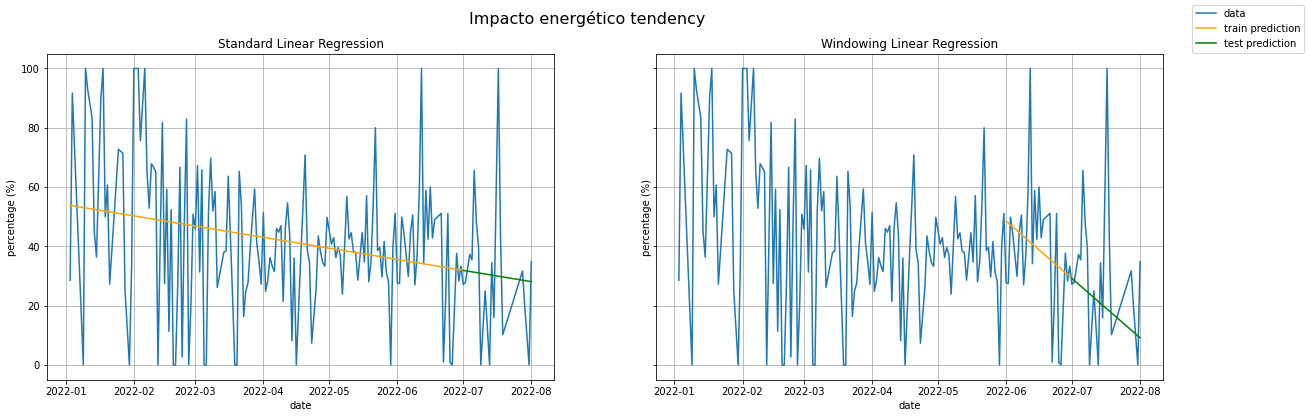

Accuracy for Standard Linear Regression
Train RMSE:	23.4711
Test RMSE:	23.1120

Accuracy for Windowing Linear Regression
Train RMSE:	19.5689
Test RMSE:	25.3771


In [ ]:
plot_category('Impacto energético')

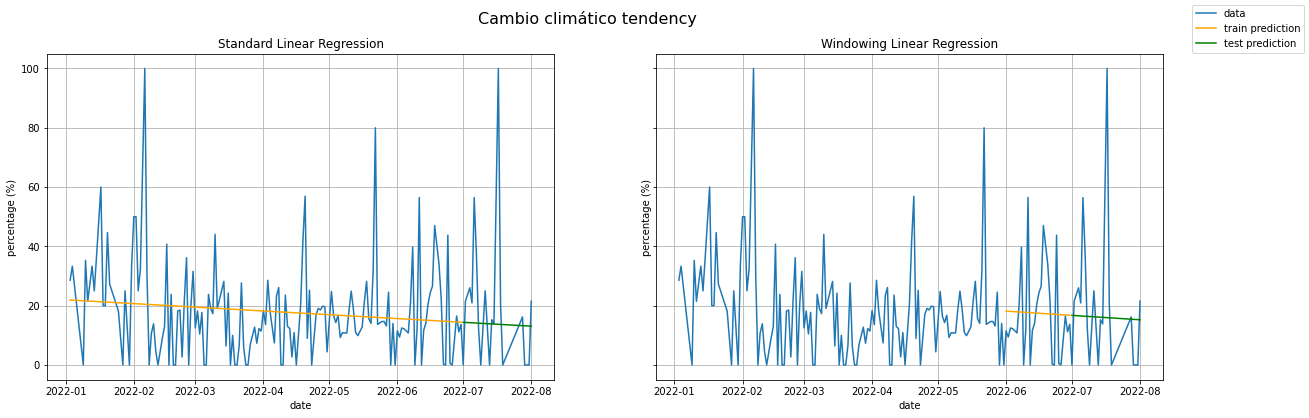

Accuracy for Standard Linear Regression
Train RMSE:	15.5217
Test RMSE:	24.4952

Accuracy for Windowing Linear Regression
Train RMSE:	15.0959
Test RMSE:	23.9841


In [ ]:
plot_category('Cambio climático')

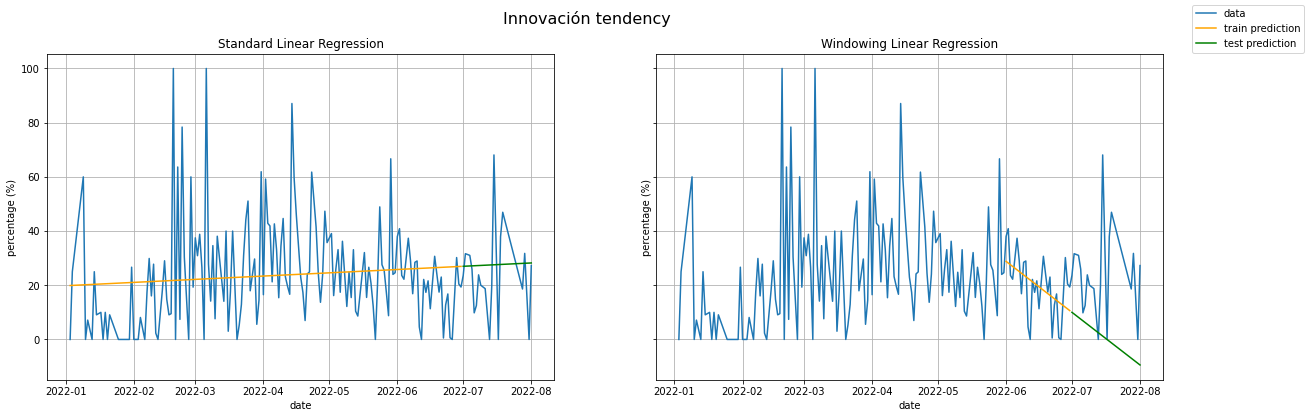

Accuracy for Standard Linear Regression
Train RMSE:	19.3112
Test RMSE:	16.7056

Accuracy for Windowing Linear Regression
Train RMSE:	10.0331
Test RMSE:	27.7213


In [ ]:
plot_category('Innovación')

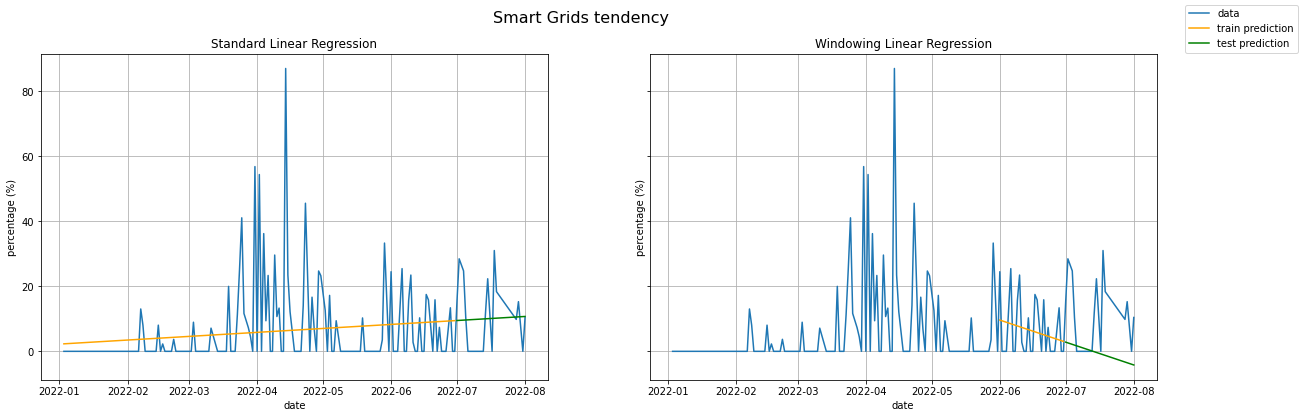

Accuracy for Standard Linear Regression
Train RMSE:	12.4092
Test RMSE:	10.5050

Accuracy for Windowing Linear Regression
Train RMSE:	8.6112
Test RMSE:	14.9485


In [ ]:
plot_category('Smart Grids')

In order to compare the performance between models, we should look for the model that has a lower error on unseen data (Test RMSE). In general, a Standard Linear Regression provides better results.